In [7]:
import os
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import shutil


In [8]:
# ==============================
# 3.1 Metric Logger Classes
# ==============================

class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a window or the global series average."""
    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value):
        self.deque.append(value)
        self.count +=1
        self.total += value

    @property
    def median(self):
        d = sorted(self.deque)
        n = len(d)
        if n == 0:
            return 0
        if n % 2 == 1:
            return d[n//2]
        else:
            return (d[n//2 -1] + d[n//2])/2

    @property
    def avg(self):
        d = self.deque
        if not d:
            return 0
        return sum(d)/len(d)

    @property
    def global_avg(self):
        if self.count ==0:
            return 0
        return self.total / self.count

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg
        )

class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if header:
            print(header)
        start_time = time.time()
        for obj in iterable:
            yield obj
            i +=1
        total_time = time.time() - start_time
        print(f"Total time: {total_time:.4f} seconds")

def reduce_dict(input_dict, average=True):
    """
    Reduce the values in the dictionary from all processes so that all
    processes have the averaged results.
    """
    # This implementation assumes single-process training
    # If using distributed training, modify accordingly
    return input_dict

# ==============================
# 3.2 Define collate_fn and Update MetricLogger
# ==============================

def collate_fn(batch):
    """
    Custom collate function to handle batches of images and targets.
    
    Args:
        batch (list of tuples): Each tuple contains an image and its target.
        
    Returns:
        tuple: Tuple containing lists of images and targets.
    """
    return tuple(zip(*batch))

class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def add_meter(self, name, meter):
        """
        Add a meter to track a specific metric.
        
        Args:
            name (str): Name of the metric.
            meter (SmoothedValue): Instance of SmoothedValue to track the metric.
        """
        self.meters[name] = meter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if header:
            print(header)
        start_time = time.time()
        for obj in iterable:
            yield obj
            i +=1
            if i % print_freq == 0:
                print(f"[{i}/{len(iterable)}] {str(self)}")
        total_time = time.time() - start_time
        print(f"Total time: {total_time:.4f} seconds")


In [9]:
# ==============================
# 4.1 Dataset Class
# ==============================

class TextImageDataset(Dataset):
    def __init__(self, root, transforms=None):
        """
        Args:
            root (string): Root directory of the dataset (e.g., 'digit-detection/train').
            transforms (callable, optional): Optional transform to be applied on a sample.
        """
        self.root = root
        self.transforms = transforms
        self.images_dir = os.path.join(root, "images")
        self.labels_dir = os.path.join(root, "labels")
        
        if not os.path.exists(self.images_dir):
            raise FileNotFoundError(f"Images directory {self.images_dir} does not exist.")
        if not os.path.exists(self.labels_dir):
            raise FileNotFoundError(f"Labels directory {self.labels_dir} does not exist.")
        
        self.imgs = list(sorted(os.listdir(self.images_dir)))
        self.labels = list(sorted(os.listdir(self.labels_dir)))
        assert len(self.imgs) == len(self.labels), "Mismatch between images and labels"

        # Define class names (digits 0-9)
        self.class_names = [str(i) for i in range(10)]
        self.class_to_idx = {cls: idx +1 for idx, cls in enumerate(self.class_names)}  # +1 for background

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        # Load labels
        label_path = os.path.join(self.labels_dir, self.labels[idx])
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # skip malformed lines
                cls, x_center, y_center, width, height = parts
                if cls not in self.class_to_idx:
                    continue  # skip unknown classes
                cls_id = self.class_to_idx[cls]
                x_center = float(x_center) * img_width
                y_center = float(y_center) * img_height
                width = float(width) * img_width
                height = float(height) * img_height
                x_min = x_center - width / 2
                y_min = y_center - height / 2
                x_max = x_center + width / 2
                y_max = y_center + height / 2
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(cls_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Assume all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


In [10]:
# ==============================
# 5.1 Transforms
# ==============================

def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = T.ToTensor()(image)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if torch.rand(1) < self.flip_prob:
            image = T.functional.hflip(image)
            width, _ = image.shape[2], image.shape[1]
            boxes = target['boxes']
            boxes = boxes.clone()
            boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
            target['boxes'] = boxes
        return image, target


In [36]:
# ==============================
# 6.1 Model Setup
# ==============================

def get_model(num_classes):
    # Load a pre-trained model for classification and return
    # only the features
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [37]:
# ==============================
# 7.1 Engine Functions
# ==============================

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{avg:.6f}'))
    metric_logger.add_meter('loss', SmoothedValue(window_size=1, fmt='{avg:.4f}'))

    for i, (images, targets) in enumerate(metric_logger.log_every(data_loader, print_freq, epoch)):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Reduce losses
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        # Record loss
        loss_value = losses_reduced.item()
        metric_logger.update(loss=loss_value, lr=optimizer.param_groups[0]["lr"])

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


def evaluate(model, data_loader, device):
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = "Test:"

    with torch.no_grad():
        for images, targets in metric_logger.log_every(data_loader, 100, header):
            images = list(img.to(device) for img in images)
            outputs = model(images)

            # Here you can implement evaluation metrics like mAP
            # For simplicity, we'll just pass
    print("Evaluation complete.")


In [39]:
import torch
import numpy as np

def calculate_iou(boxA, boxB):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Args:
        boxA (array-like): [x1, y1, x2, y2]
        boxB (array-like): [x1, y1, x2, y2]
    
    Returns:
        float: IoU value.
    """
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # Compute the area of intersection rectangle
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight
    
    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # Compute the IoU
    iou = interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0
    
    return iou

def evaluate_metrics(model, data_loader, device, iou_threshold=0.5, score_threshold=0.5):
    """
    Evaluate Precision, Recall, and F1 Score for the given model and data loader.
    
    Args:
        model: Trained object detection model.
        data_loader: DataLoader for the dataset to evaluate.
        device: torch.device object.
        iou_threshold: IoU threshold to consider a detection as True Positive.
        score_threshold: Minimum confidence score to consider a detection.
    
    Returns:
        tuple: (precision, recall, f1_score)
    """
    model.eval()
    TP = 0
    FP = 0
    FN = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)
            
            for i in range(len(images)):
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                gt_labels = targets[i]['labels'].cpu().numpy()
                
                pred_boxes = outputs[i]['boxes'].cpu().numpy()
                pred_labels = outputs[i]['labels'].cpu().numpy()
                pred_scores = outputs[i]['scores'].cpu().numpy()
                
                # Filter out predictions with low scores
                keep = pred_scores >= score_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_scores = pred_scores[keep]
                
                # Create a list to keep track of matched ground truths
                matched_gt = set()
                
                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    # Find the best matching ground truth box for this prediction
                    best_iou = 0
                    best_gt_idx = -1
                    for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                        if gt_label != pred_label:
                            continue
                        if gt_idx in matched_gt:
                            continue
                        iou = calculate_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx
                    if best_iou >= iou_threshold and best_gt_idx != -1:
                        TP +=1
                        matched_gt.add(best_gt_idx)
                    else:
                        FP +=1
                # Any ground truth not matched is a False Negative
                FN += len(gt_boxes) - len(matched_gt)
    
    precision = TP / (TP + FP) if (TP + FP) >0 else 0
    recall = TP / (TP + FN) if (TP + FN) >0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) >0 else 0
    return precision, recall, f1_score



In [54]:
def main():
    # Paths to your dataset
    dataset_root = "/kaggle/input/digit-detection"  # Updated to your actual dataset root
    train_dir = os.path.join(dataset_root, "train")
    valid_dir = os.path.join(dataset_root, "valid")
    test_dir = os.path.join(dataset_root, "test")

    # Verify dataset directories exist
    for dir_path in [train_dir, valid_dir, test_dir]:
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory {dir_path} does not exist. Please check your dataset path.")

    # Use our dataset and defined transformations
    dataset = TextImageDataset(train_dir, transforms=get_transform(train=True))
    dataset_valid = TextImageDataset(valid_dir, transforms=get_transform(train=False))
    dataset_test = TextImageDataset(test_dir, transforms=get_transform(train=False))

    # Define training and validation data loaders
    data_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4,
                             collate_fn=collate_fn)
    data_loader_valid = DataLoader(dataset_valid, batch_size=8, shuffle=False, num_workers=4,
                                   collate_fn=collate_fn)
    data_loader_test = DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=4,
                                  collate_fn=collate_fn)

    # Get the model using our helper function
    num_classes = 11  # 10 digits + background
    model = get_model(num_classes)

    # Move model to the right device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01,
                                momentum=0.9, weight_decay=0.0005)

    # And a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    num_epochs = 10

    for epoch in range(num_epochs):
        # Train for one epoch, printing every 10 iterations
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # Update the learning rate
        lr_scheduler.step()
        
        # Compute metrics on training data
        train_precision, train_recall, train_f1 = evaluate_metrics(model, data_loader, device)
        print(f"Training Metrics - Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
        
        # Compute metrics on validation data
        val_precision, val_recall, val_f1 = evaluate_metrics(model, data_loader_valid, device)
        print(f"Validation Metrics - Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")
        
        # Evaluate on the validation dataset
        evaluate(model, data_loader_valid, device=device)

    print("Training complete!")

    # Evaluate metrics on the test dataset
    test_precision, test_recall, test_f1 = evaluate_metrics(model, data_loader_test, device)
    print(f"Test Metrics - Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), "fasterrcnn_text_digits.pth")

    # Visualize some predictions
    visualize_predictions(model, dataset_test, device, num_images=10, threshold=0.5)


In [55]:
# ==============================
# 8.1 Visualization
# ==============================

def visualize_predictions(model, dataset, device, num_images=5, threshold=0.5):
    model.eval()
    for i in range(num_images):
        img, target = dataset[i]
        with torch.no_grad():
            prediction = model([img.to(device)])

        img = img.permute(1, 2, 0).cpu().numpy()
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        ax = plt.gca()

        boxes = prediction[0]['boxes'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()

        for box, score, label in zip(boxes, scores, labels):
            if score > threshold:
                x_min, y_min, x_max, y_max = box
                ax.add_patch(plt.Rectangle((x_min, y_min),
                                           x_max - x_min,
                                           y_max - y_min,
                                           fill=False,
                                           color='red',
                                           linewidth=2))
                label_name = dataset.class_names[label-1] if label-1 < len(dataset.class_names) else str(label)
                ax.text(x_min, y_min, f"{label_name}: {score:.2f}",
                        bbox=dict(facecolor='yellow', alpha=0.5))
        plt.axis('off')
        plt.show()


Epoch 1/10
[10/44] lr: 0.010000  loss: 1.6296
[20/44] lr: 0.010000  loss: 1.1759
[30/44] lr: 0.010000  loss: 1.1905
[40/44] lr: 0.010000  loss: 0.9536
Total time: 35.5469 seconds
Training Metrics - Precision: 0.9609, Recall: 0.0386, F1 Score: 0.0742
Validation Metrics - Precision: 0.8000, Recall: 0.0042, F1 Score: 0.0083
Test:
Total time: 5.0508 seconds
Evaluation complete.
Epoch 2/10
1
[10/44] lr: 0.010000  loss: 0.9979
[20/44] lr: 0.010000  loss: 0.9161
[30/44] lr: 0.010000  loss: 0.8892
[40/44] lr: 0.010000  loss: 0.8102
Total time: 35.3732 seconds
Training Metrics - Precision: 0.6980, Recall: 0.2588, F1 Score: 0.3776
Validation Metrics - Precision: 0.1673, Recall: 0.0429, F1 Score: 0.0683
Test:
Total time: 5.0332 seconds
Evaluation complete.
Epoch 3/10
2
[10/44] lr: 0.010000  loss: 0.6391
[20/44] lr: 0.010000  loss: 0.5928
[30/44] lr: 0.010000  loss: 0.6175
[40/44] lr: 0.010000  loss: 0.4672
Total time: 35.3459 seconds
Training Metrics - Precision: 0.7993, Recall: 0.6722, F1 Score:

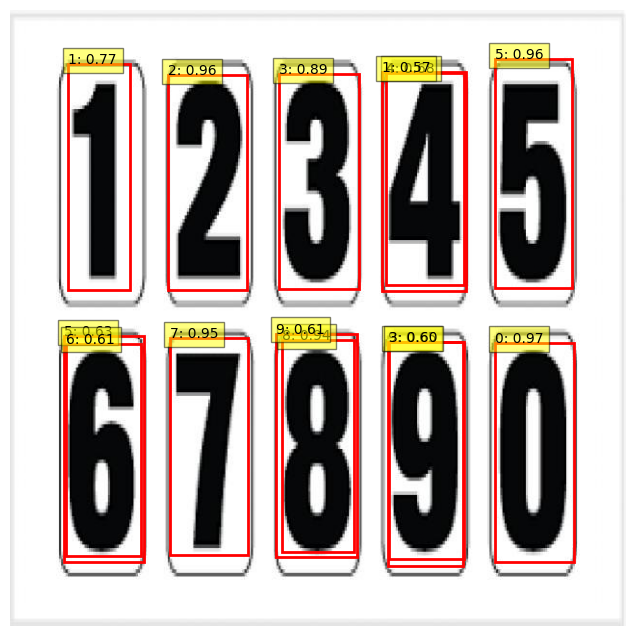

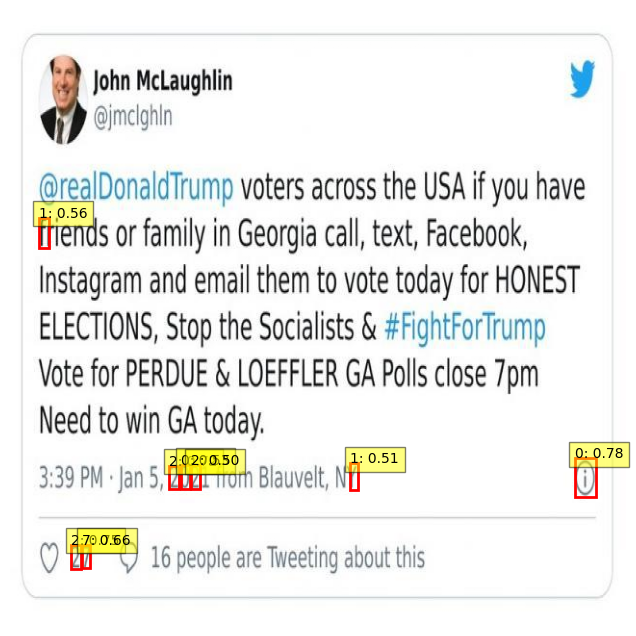

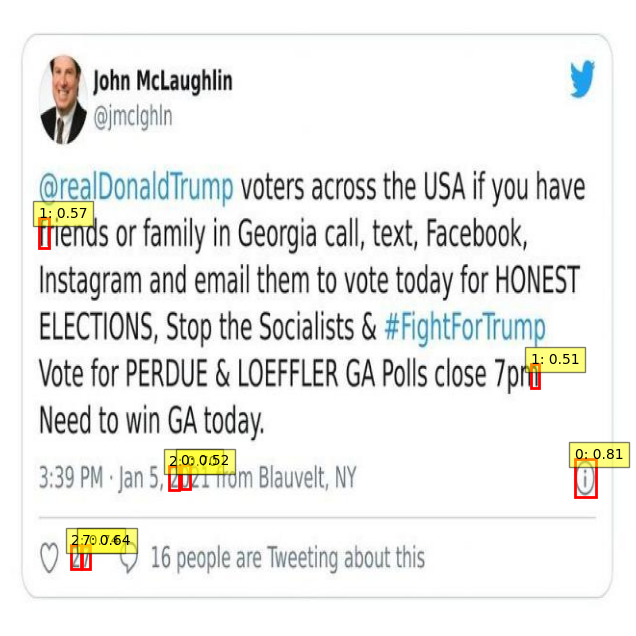

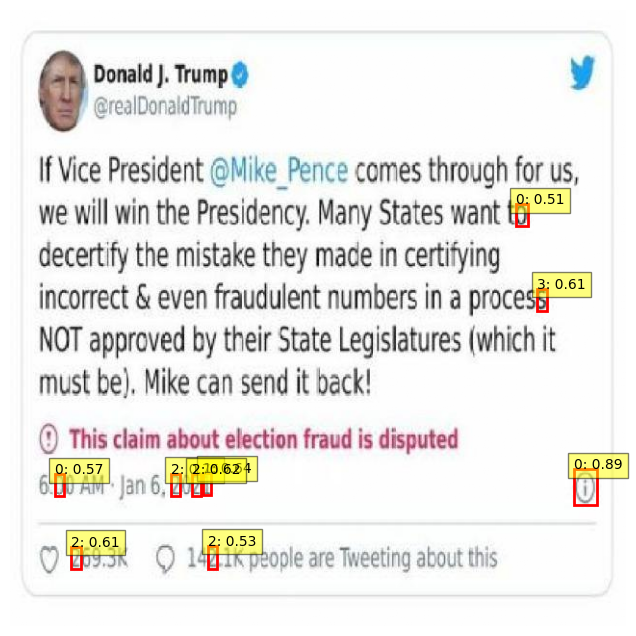

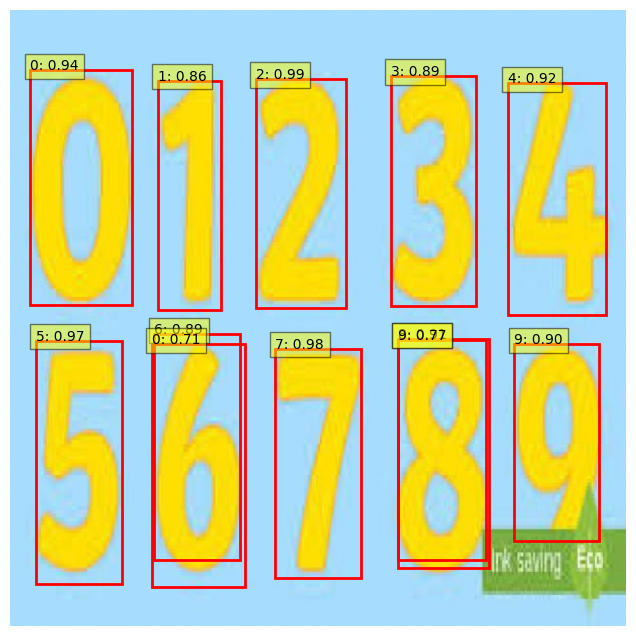

Training complete!


NameError: name 'data_loader_test' is not defined

In [56]:
# ==============================
# 11.1 Execute Training
# ==============================

main()
# After training completes
print("Training complete!")

# Evaluate metrics on the test dataset
test_precision, test_recall, test_f1 = evaluate_metrics(model, data_loader_test, device)
print(f"Test Metrics - Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")


In [34]:
def evaluate_and_visualize_image(model, image, ground_truth_boxes, ground_truth_labels, class_names, device, iou_threshold=0.5, score_threshold=0.5):
    """
    Evaluate Precision, Recall, and F1 Score for a single image and visualize predictions.

    Args:
        model: Trained object detection model.
        image (PIL Image or Tensor): The image to evaluate.
        ground_truth_boxes (list of lists or numpy arrays): Ground truth bounding boxes [x_min, y_min, x_max, y_max].
        ground_truth_labels (list of ints): Ground truth labels corresponding to the boxes.
        class_names (list of str): List of class names indexed by label.
        device: torch.device object.
        iou_threshold (float): IoU threshold to consider a detection as True Positive.
        score_threshold (float): Minimum confidence score to consider a detection.

    Returns:
        tuple: (precision, recall, f1_score)
    """
    model.eval()
    
    # Preprocess the image
    if isinstance(image, Image.Image):
        # If image is a PIL Image, apply transforms
        transform = get_transform(train=False)
        image, _ = transform(image, {})
    elif isinstance(image, torch.Tensor):
        # If image is already a tensor, ensure it's in the right shape
        image = image.to(device)
    else:
        raise ValueError("Unsupported image type. Must be PIL Image or torch Tensor.")
    
    # Add batch dimension and move to device
    image = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)[0]

    gt_boxes = np.array(ground_truth_boxes)
    gt_labels = np.array(ground_truth_labels)

    pred_boxes = output['boxes'].cpu().numpy()
    pred_labels = output['labels'].cpu().numpy()
    pred_scores = output['scores'].cpu().numpy()

    # Filter out predictions with low scores
    keep = pred_scores >= score_threshold
    pred_boxes = pred_boxes[keep]
    pred_labels = pred_labels[keep]
    pred_scores = pred_scores[keep]

    # Initialize counts
    TP = 0
    FP = 0
    FN = 0
    matched_gt = set()

    for pred_box, pred_label in zip(pred_boxes, pred_labels):
        # Find the best matching ground truth box for this prediction
        best_iou = 0
        best_gt_idx = -1
        for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
            if gt_label != pred_label:
                continue
            if gt_idx in matched_gt:
                continue
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx
        if best_iou >= iou_threshold and best_gt_idx != -1:
            TP +=1
            matched_gt.add(best_gt_idx)
        else:
            FP +=1
    # Any ground truth not matched is a False Negative
    FN = len(gt_boxes) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) >0 else 0
    recall = TP / (TP + FN) if (TP + FN) >0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) >0 else 0

    # Visualization
    img = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    ax = plt.gca()

    # Plot ground truth boxes
    for gt_box, gt_label in zip(gt_boxes, gt_labels):
        x_min, y_min, x_max, y_max = gt_box
        ax.add_patch(plt.Rectangle((x_min, y_min),
                                   x_max - x_min,
                                   y_max - y_min,
                                   fill=False,
                                   color='green',
                                   linewidth=2))
        ax.text(x_min, y_min, f"GT: {class_names[gt_label-1]}",
                bbox=dict(facecolor='yellow', alpha=0.5))

    # Plot predicted boxes
    for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores):
        x_min, y_min, x_max, y_max = pred_box
        ax.add_patch(plt.Rectangle((x_min, y_min),
                                   x_max - x_min,
                                   y_max - y_min,
                                   fill=False,
                                   color='red',
                                   linewidth=2))
        ax.text(x_min, y_min, f"P: {class_names[pred_label-1]} ({pred_score:.2f})",
                bbox=dict(facecolor='blue', alpha=0.5))

    plt.axis('off')
    plt.title(f"Evaluation - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
    plt.show()

    return precision, recall, f1_score


In [57]:
# Define class names (digits 0-9)
class_names = [str(i) for i in range(10)]  # ['0', '1', ..., '9']

# Define device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Number of classes (10 digits + background)
num_classes = 11

# Initialize the model
model = get_model(num_classes)

# Path to the saved model
model_path = "/kaggle/working/fasterrcnn_text_digits.pth"

# Load the model state dictionary
model.load_state_dict(torch.load(model_path, map_location=device))

# Move the model to the device
model.to(device)

# Set the model to evaluation mode
model.eval()


/tmp/ipykernel_30/2489819038.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

/tmp/ipykernel_30/3990499195.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded successfully!
Test Metrics - Precision: 0.6733, Recall: 0.5837, F1 Score: 0.6253


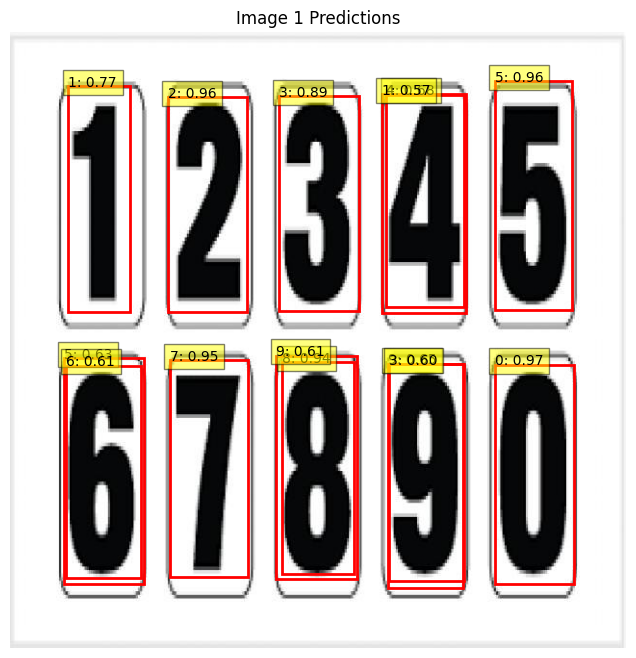

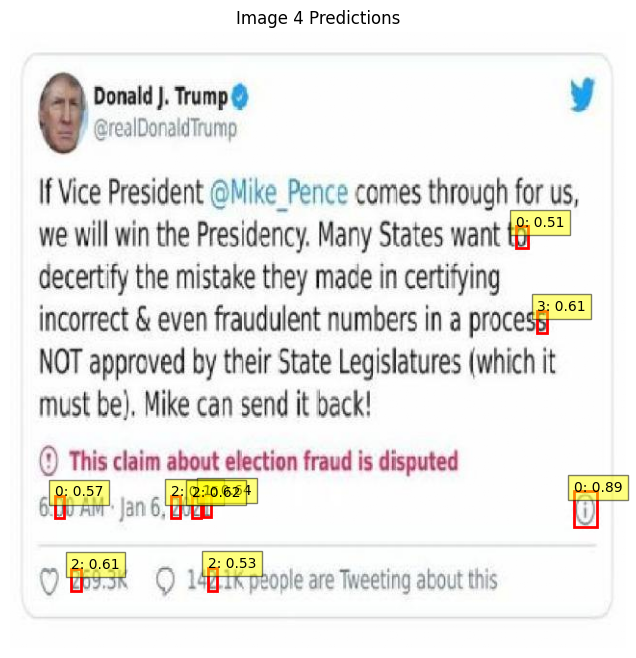

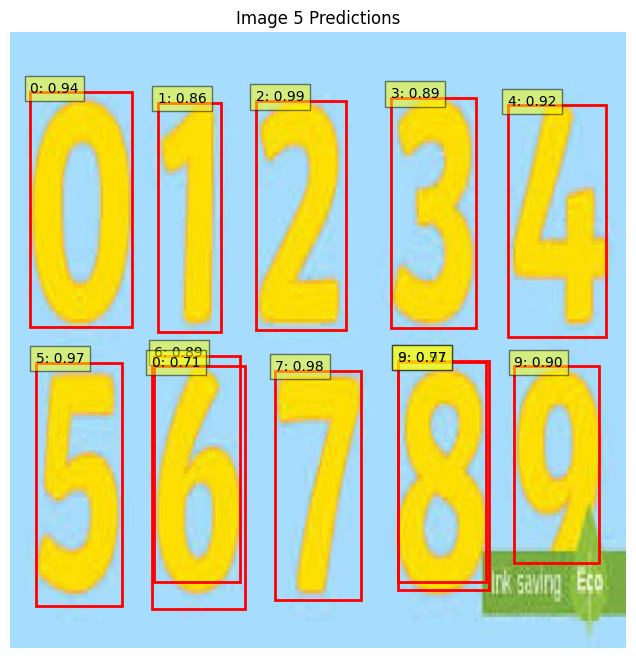

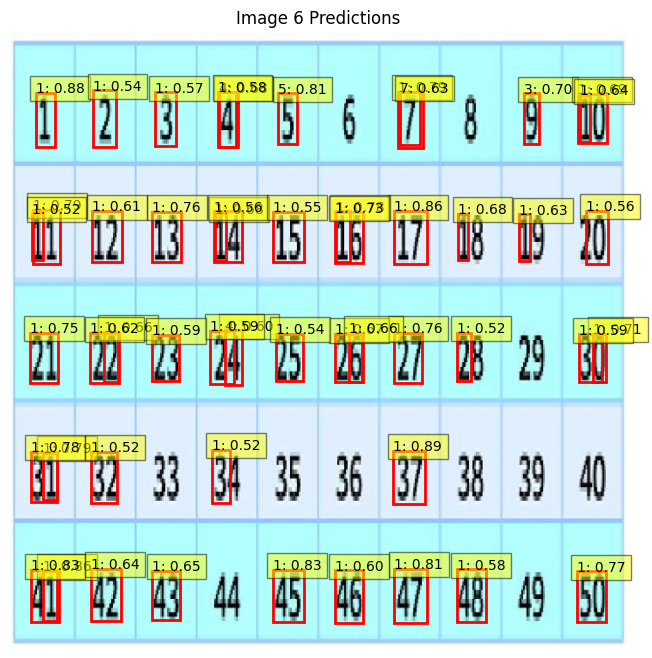

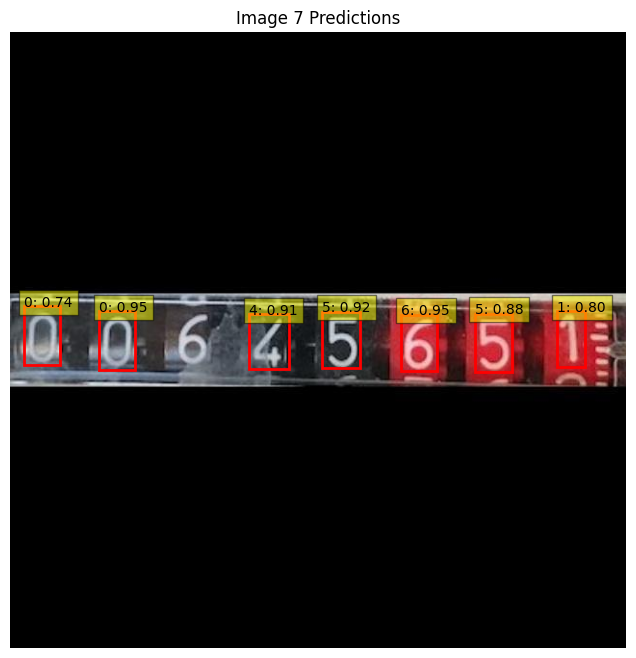

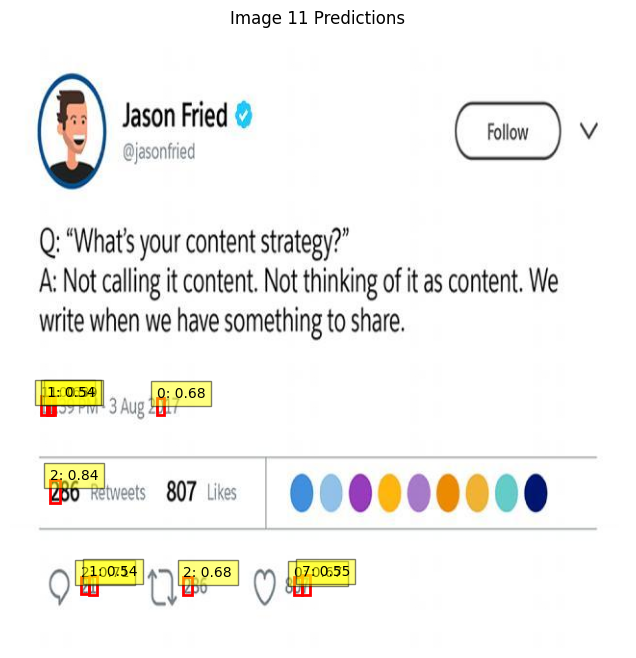

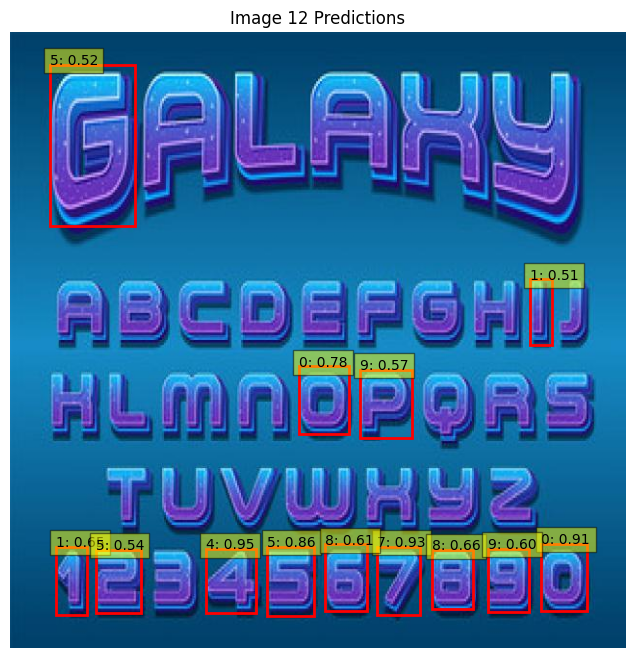

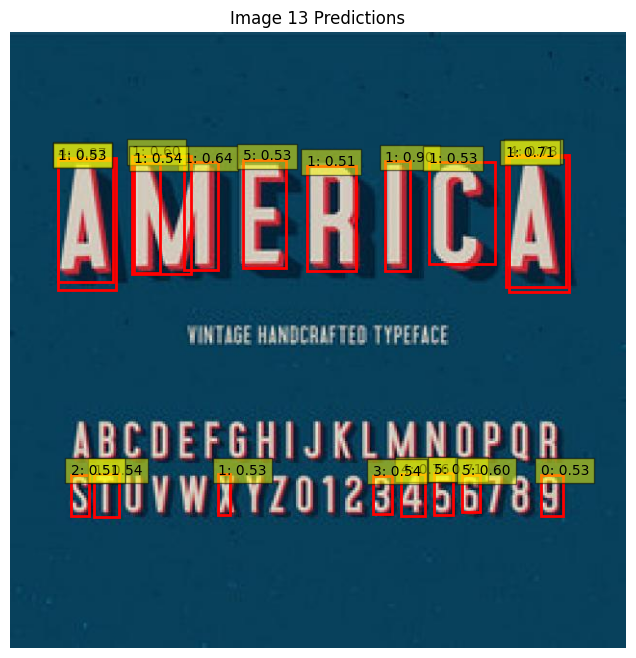

In [61]:
# Step 1: Define class names and device
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class_names = [str(i) for i in range(10)]  # ['0', '1', ..., '9']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Step 2: Initialize and load the model
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

def get_model(num_classes):
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 11  # 10 digits + background
model = get_model(num_classes)
model_path = "/kaggle/working/fasterrcnn_text_digits.pth"  # Ensure this path is correct
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print("Model loaded successfully!")

# Step 3: Prepare the test dataset and DataLoader
from torch.utils.data import DataLoader

test_dir = "/kaggle/input/digit-detection/test"  # Update as necessary
dataset_test = TextImageDataset(test_dir, transforms=get_transform(train=False))
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Step 4: Define the evaluation metrics function
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0
    return iou

def evaluate_metrics(model, data_loader, device, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    TP = 0
    FP = 0
    FN = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for i in range(len(images)):
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                gt_labels = targets[i]['labels'].cpu().numpy()

                pred_boxes = outputs[i]['boxes'].cpu().numpy()
                pred_labels = outputs[i]['labels'].cpu().numpy()
                pred_scores = outputs[i]['scores'].cpu().numpy()

                # Filter out predictions with low scores
                keep = pred_scores >= score_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]
                pred_scores = pred_scores[keep]

                # Create a list to keep track of matched ground truths
                matched_gt = set()

                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    # Find the best matching ground truth box for this prediction
                    best_iou = 0
                    best_gt_idx = -1
                    for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                        if gt_label != pred_label:
                            continue
                        if gt_idx in matched_gt:
                            continue
                        iou = calculate_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx
                    if best_iou >= iou_threshold and best_gt_idx != -1:
                        TP +=1
                        matched_gt.add(best_gt_idx)
                    else:
                        FP +=1
                # Any ground truth not matched is a False Negative
                FN += len(gt_boxes) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) >0 else 0
    recall = TP / (TP + FN) if (TP + FN) >0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) >0 else 0
    return precision, recall, f1_score

# Step 5: Define the visualization function
def visualize_predictions(model, dataset, device, num_images=5, threshold=0.5):
    """
    Visualize model predictions on a subset of images from the dataset.

    Args:
        model: Trained object detection model.
        dataset: Instance of TextImageDataset.
        device: torch.device object.
        num_images (int): Number of images to visualize.
        threshold (float): Confidence threshold to filter predictions.
    """
    model.eval()
    for i in range(num_images):
        img, target = dataset[i]
        with torch.no_grad():
            prediction = model([img.to(device)])

        img = img.permute(1, 2, 0).cpu().numpy()
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        ax = plt.gca()

        boxes = prediction[0]['boxes'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()

        for box, score, label in zip(boxes, scores, labels):
            if score > threshold:
                x_min, y_min, x_max, y_max = box
                ax.add_patch(plt.Rectangle((x_min, y_min),
                                           x_max - x_min,
                                           y_max - y_min,
                                           fill=False,
                                           color='red',
                                           linewidth=2))
                label_name = dataset.class_names[label-1] if label-1 < len(dataset.class_names) else str(label)
                ax.text(x_min, y_min, f"{label_name}: {score:.2f}",
                        bbox=dict(facecolor='yellow', alpha=0.5))
        plt.axis('off')
        plt.title(f"Image {i+1} Predictions")
        plt.show()

# Step 6: Evaluate Metrics on the Test Set
test_precision, test_recall, test_f1 = evaluate_metrics(model, data_loader_test, device)

print(f"Test Metrics - Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

# Step 7: Visualize Predictions on Test Images
visualize_predictions(model, dataset_test, device, num_images=15, threshold=0.5)

In [45]:
from PIL import Image

# Example class names
class_names = [str(i) for i in range(10)]  # ['0', '1', ..., '9']

# Load an image (replace with your image path)
image_path = "/kaggle/input/scrst123/Screenshot from 2024-11-09 10-35-44.png"
image = Image.open(image_path).convert("RGB")

# Define ground truth boxes and labels
# Example: Detecting digit '3' and '7'
ground_truth_boxes = [
    [50, 30, 200, 180],  # Box for digit '3'
    [220, 100, 350, 250]  # Box for digit '7'
]
ground_truth_labels = [
    4,  # Assuming class '3' has label 4 (since background is 0 and labels start at 1)
    8   # Assuming class '7' has label 8
]

# Evaluate and visualize
precision, recall, f1 = evaluate_and_visualize_image(
    model=model,
    image=image,
    ground_truth_boxes=ground_truth_boxes,
    ground_truth_labels=ground_truth_labels,
    class_names=class_names,
    device=device,
    iou_threshold=0.5,
    score_threshold=0.5
)

print(f"Single Image Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Single Image Metrics - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
